<h1 align="center">Predizione di temperatura e salinità dell'oceano tramite ML</h1>

<p align="center"><strong>Federico Sanchini</strong></p>
<p align="center">26/06/2025</p>

---


## **Regressione lineare con regolarizzazione di Ridge e Kernel di Mercer per la predizione di temperatura e salinità dell'oceano**

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Caricare il file CSV con separatore ";"
file_path = 'bottle.csv'
df = pd.read_csv(file_path, sep=';')

# Visualizzare le prime righe del dataframe
df.head()

C:\Users\feder\AppData\Local\Temp\ipykernel_13108\3990100263.py:14: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';')


,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,dic-01,dic-02,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Cst_Cnt              864863 non-null  int64  
 1   Btl_Cnt              864863 non-null  int64  
 2   Sta_ID               864863 non-null  object 
 3   Depth_ID             864863 non-null  object 
 4   Depthm               864863 non-null  int64  
 5   T_degC               853900 non-null  float64
 6   Salnty               817509 non-null  float64
 7   O2ml_L               696201 non-null  float64
 8   STheta               812174 non-null  float64
 9   O2Sat                661274 non-null  float64
 10  Oxy_µmol/Kg          661268 non-null  float64
 11  BtlNum               118667 non-null  float64
 12  RecInd               864863 non-null  int64  
 13  T_prec               853900 non-null  float64
 14  T_qual               23127 non-null   float64
 15  S_prec           

Le colonne di interesse sono:

- Depthm : Profondità in metri
- T_degC : Temperatura in Celsius
- Salnty : Salinità
- O2ml_L : Millilitri di ossigeno disciolto per litro d'acqua marina
- STheta : Densità potenziale dell'acqua ($\sigma_{\theta}$)
- O2Sat : Saturazione di ossigeno 
- Oxy_µmol/Kg : Ossigeno in micromoli per kilogrammo d'acqua marina
- PO4uM, SiO3uM, NO2uM, NO3uM, NH3uM : concentrazioni di vari composti

In [19]:
df = df.iloc[:, [4, 5, 6, 7, 8, 9, 10, 25, 27, 29, 31, 33]]
df = df.rename(columns={'Depthm': 'Depth', 'T_degC': 'T', 'Salnty': 'Salinity'})
df.head()

,Depth,T,Salinity,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,PO4uM,SiO3uM,NO2uM,NO3uM,NH3uM
0,0,10.50,33.440,NaN,25.649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,10.46,33.440,NaN,25.656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,10.46,33.437,NaN,25.654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19,10.45,33.420,NaN,25.643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,10.45,33.421,NaN,25.643,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

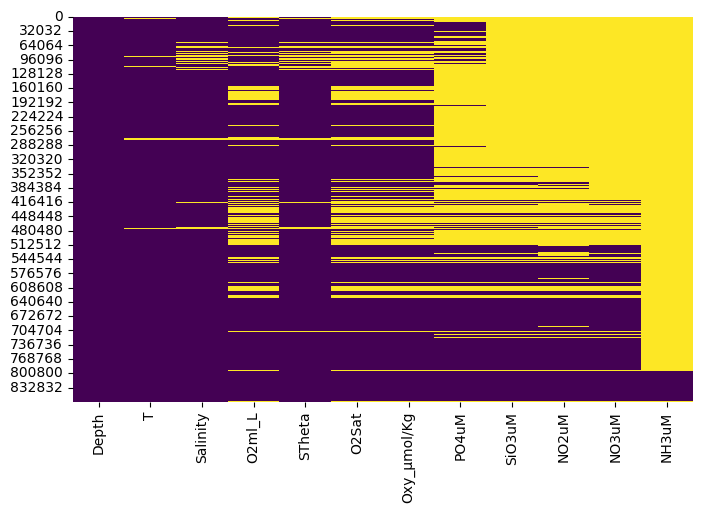

In [20]:
# Visualizzazione dei valori NaN nel data frame
plt.rcParams["figure.figsize"] = (8,5)
sns.heatmap(df.isna(), cbar=False, cmap='viridis')

data frame ripulito dai dati mancanti
righe rimanenti: 64873


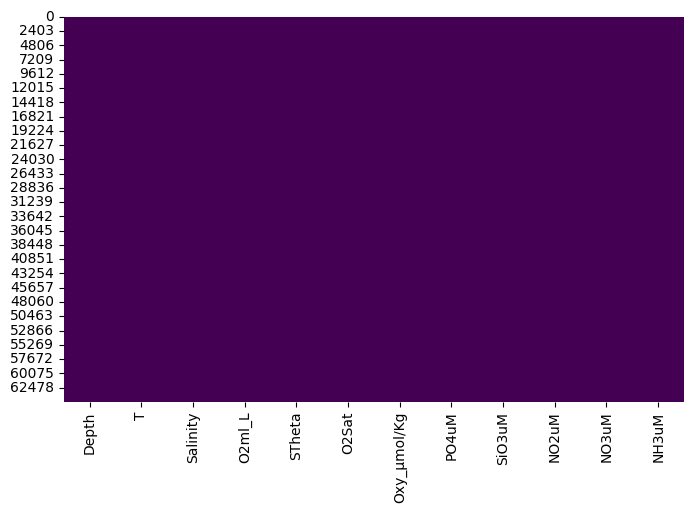

In [21]:
df = df.dropna()  # Sovrascrivi df con la versione senza valori NaN
df = df.reset_index(drop=True)  # Reset dell'indice

# Visualizza la heatmap dopo la pulizia
plt.rcParams["figure.figsize"] = (8,5)
sns.heatmap(df.isna(), cbar=False, cmap='viridis')

print("data frame ripulito dai dati mancanti")
print("righe rimanenti:", len(df))

In [22]:
df.head()

,Depth,T,Salinity,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,PO4uM,SiO3uM,NO2uM,NO3uM,NH3uM
0,0,12.14,33.537,5.46,25.427,89.7,237.7971,0.88,9.6,0.26,8.4,0.12
1,2,12.14,33.537,5.46,25.427,89.7,237.7971,0.88,9.6,0.26,8.4,0.12
2,6,12.14,33.538,5.45,25.428,89.5,237.3614,0.87,9.5,0.26,8.4,0.11
3,10,12.15,33.537,5.46,25.425,89.7,237.7976,0.87,9.5,0.26,8.4,0.13
4,20,12.15,33.538,5.46,25.426,89.7,237.7974,0.88,9.5,0.26,8.3,0.16


Provo ora a plottare T e Salinity in funzione delle altre features, per verificare se hanno una dipendenza lineare o più complessa.

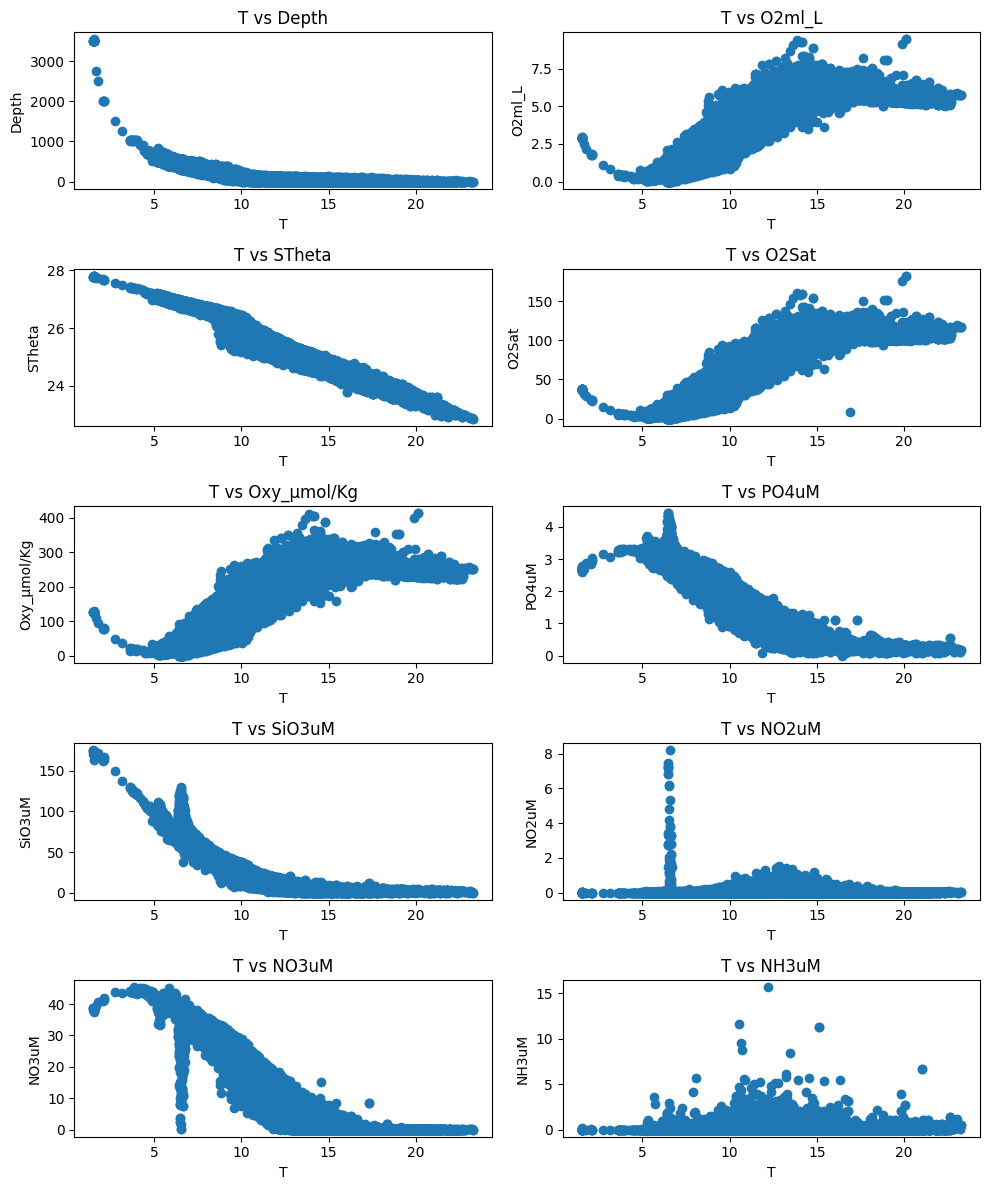

In [23]:
variables = ['Depth', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM', 'NH3uM']

# Creazione di una griglia con 5 righe e 2 colonne
fig, axes = plt.subplots(5, 2, figsize=(10, 12))

# Ciclo sulle variabili e sugli assi
for i, var in enumerate(variables):
    ax = axes[i // 2, i % 2]  # Seleziona la posizione corretta
    ax.scatter(df['T'], df[var])
    ax.set_title(f"T vs {var}")
    ax.set_xlabel("T")
    ax.set_ylabel(var)

# Layout migliore per evitare sovrapposizioni
plt.tight_layout()
plt.show()

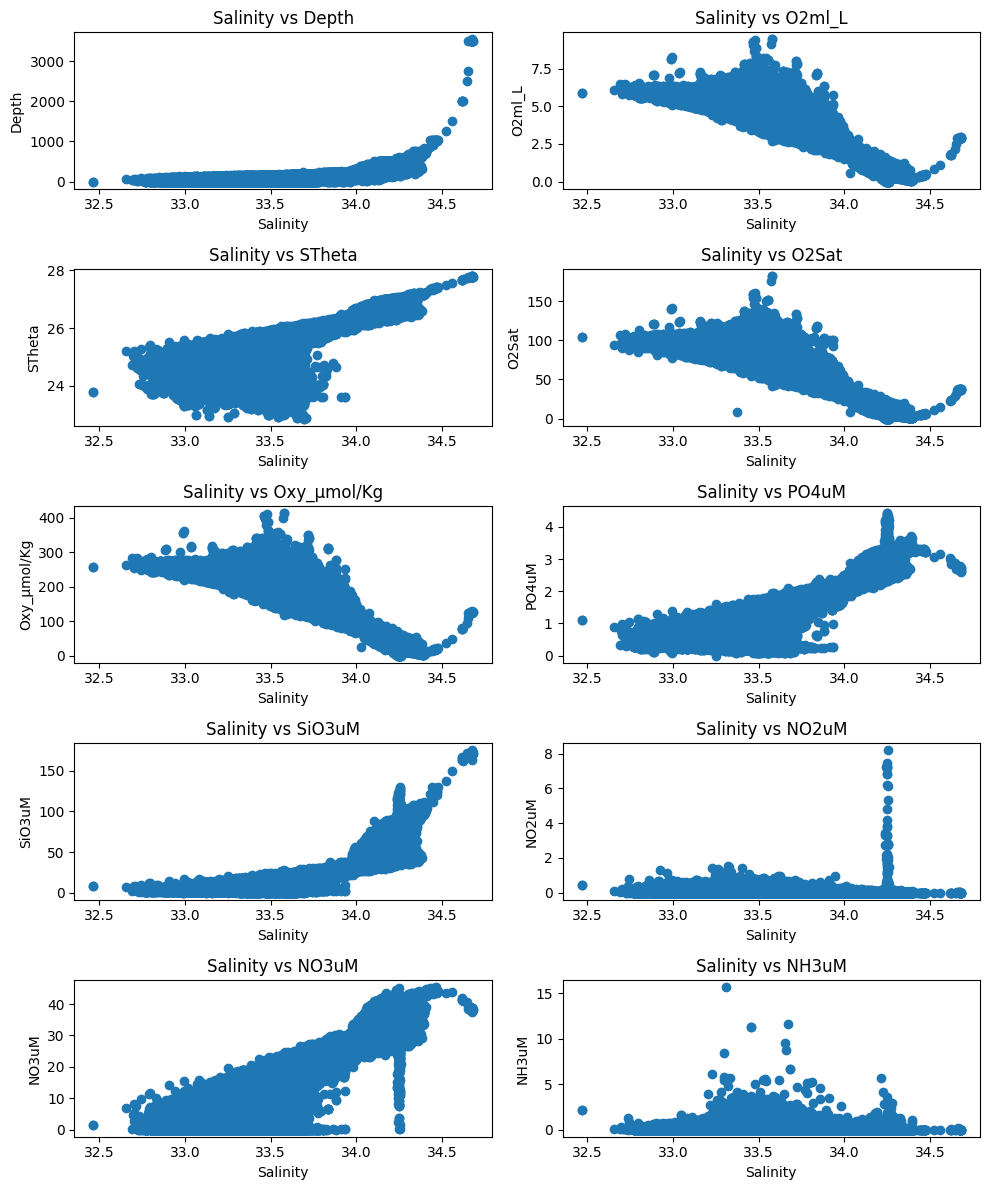

In [24]:
variables = ['Depth', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'PO4uM', 'SiO3uM', 'NO2uM', 'NO3uM', 'NH3uM']

# Creazione di una griglia con 5 righe e 2 colonne
fig, axes = plt.subplots(5, 2, figsize=(10, 12))

# Ciclo sulle variabili e sugli assi
for i, var in enumerate(variables):
    ax = axes[i // 2, i % 2]  # Seleziona la posizione corretta
    ax.scatter(df['Salinity'], df[var])
    ax.set_title(f"Salinity vs {var}")
    ax.set_xlabel("Salinity")
    ax.set_ylabel(var)

# Layout migliore per evitare sovrapposizioni
plt.tight_layout()
plt.show()

Sia nel caso della temperatura che nel caso della salinità la dipendenza dei label dalle features presenta andamenti complessi e non spiegabili con una semplice dipendenza di tipo lineare.

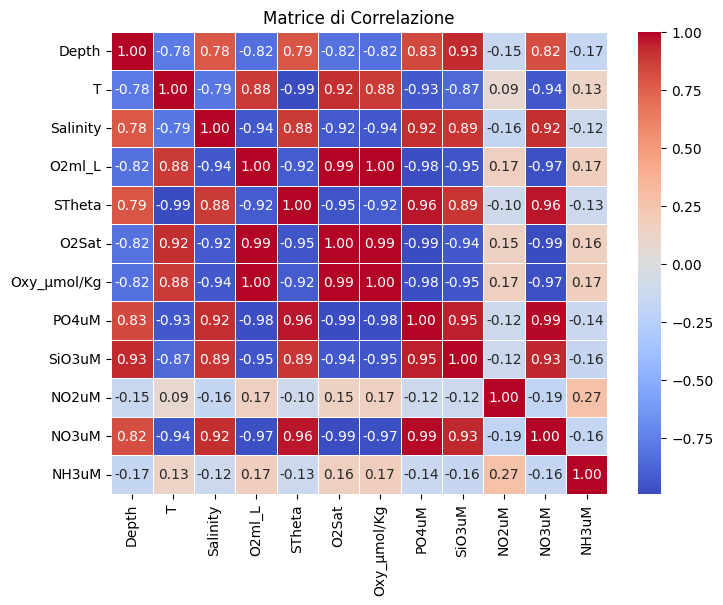

In [25]:
# Calcolare la matrice di correlazione
correlation_matrix = df.corr()

# Visualizzare la heatmap della correlazione
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice di Correlazione")
plt.show()

In [26]:
# Definisci le feature (X) e le variabili target (y)
X = df.drop(columns=['Salinity', 'T'])  # Feature
y = df[['Salinity', 'T']]  # Variabili target

# Dividi il dataset in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Regressione di Ridge**
Vista la forma di dipendenza dei label dalle altre variabili piuttosto complicata e variegata, si è scelto di implementare un predittore di tipo regressione di ridge, con l'aggiunta dell'uso di cordinate generalizzate, in modo tale da aumentare l'espressività dell'algoritmo di apprendimento.

Facciamo prima un passo indietro: la soluzione della regressione lineare "standard" si basa sull'invertibilità di $\mathbf{X^TX}$, dato il fatto che il vettore (nel caso di un singolo target) dei coefficienti $\beta$ è dato da: 

$$
\underline{\beta} = (\mathbf{X^TX})^{-1}\mathbf{X^T}y
$$

Più in generale, se si hanno più target, si ha:

$$
\mathbf{\underline{\beta}} = (\mathbf{X^TX})^{-1}\mathbf{X^TY}
$$

Inoltre:
- Se il modello di regressione ha troppi parametri o se i dati sono molto rumorosi (ossia ci sono molte fluttuazioni nei dati che non rappresentano una relazione reale), il modello può "adattarsi troppo" ai dati di addestramento, catturando anche il rumore. Questo fenomeno è chiamato **overfitting**. 
- Quando il modello è **sovradimensionato**, ad esempio, se ci sono molte variabili indipendenti rispetto ai dati disponibili, il modello può fare previsioni molto accurate sui dati di addestramento, ma fallire nel generalizzare su nuovi dati, portando a errori elevati quando viene testato su dati mai visti prima. 
- Se ci sono variabili indipendenti che sono fortemente correlate tra loro (**multicollinearità**), i coefficienti di regressione possono diventare instabili, con ampie fluttuazioni nei loro valori. Questo porta a soluzioni non affidabili che variano in modo imprevisto in base ai dati di addestramento.

La **regolarizzazione** introduce una penalizzazione sui parametri del modello (i coefficienti), riducendo la loro grandezza e impedendo che diventano troppo grandi. Questo aiuta a evitare che il modello si adatti troppo al rumore nei dati e riduce la complessità del modello. Nel caso della **regolarizzazione di Ridge** si ha:

$$
||\underline{\beta}|| ^ {2} \leq t
$$

cioè:

$$
\underline{\hat{\beta}}^{ridge} = argmin_{\beta} \left( \sum_{i=1}^{N}\left(y_i - \beta_{0} - \sum_{j=1}^{p} x_{ij}\beta_j \right)^2 + \lambda \sum_{j=1}^{P}\beta_{j}^2\right)
$$

$\lambda \geq 0 $ è il **parametro di complessità** che controlla l'entità della penalizzazione. Più è grande $\lambda$, maggiore è la prenalizzazione.
La penalizzazione tende a ridurre i coefficienti verso 0  ed a farli avvicinare tra loro.
Vi è una corrispondenza uno a uno fra $\lambda$ e $t$.

La fuzione costo è quindi:

$$
\mathit{L}(\underline{\beta}) = \sum_{i=1}^{N}(y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p}|\beta_j|^2 = (\vec{y}
- \mathbf{X}\underline{\beta})^{T}(\vec{y}
- \mathbf{X}\underline{\beta}) + \lambda\underline{\beta}^T\underline{\beta} 
$$

e minimizzando

$$
\frac{\partial \mathit{L}(\underline{\beta})}{\partial\beta_j} = - \sum 2 (y_i - \underline{x_i}^T\underline{\beta})x_{ij} + 2 \lambda \beta_j
$$
$$
\nabla_{\beta} \mathit{L} = -2 \mathbf{X}^T(\vec{y}
- \mathbf{X}\underline{\beta}) + 2\lambda\underline{\beta} = 0
$$

Da cui:

$$
-\mathbf{X}^T\vec{y} + \mathbf{X}^T\mathbf{X}\underline{\beta} + \lambda \underline{\beta} = 0
$$

ovvero:

$$
\underline{\beta} = (\mathbf{X}^T\mathbf{X} + \lambda I
)^{-1}\mathbf{X}^T\vec{y}
$$

Passiamo ora alle features generalizzate ed all'implementazione di un Kernel di Mercer.

La **matrice di design generalizzata** ha dimensione $N \times P$:

$$
\underline{\underline{X}} =
\begin{bmatrix}
\phi_{1}(\underline{x}_1) & \phi_{2}(\underline{x}_1) & ... &\phi_{P}(\underline{x}_1) \\
\phi_{1}(\underline{x}_2) & \phi_{2}(\underline{x}_2) & ... &\phi_{P}(\underline{x}_2) \\
\vdots & \vdots& \ddots & \vdots \\
\phi_{1}(\underline{x}_N) & \phi_{2}(\underline{x}_N) & ... &\phi_{P}(\underline{x}_N) \\
\end{bmatrix} = \begin{bmatrix}
h(\underline{x}_1)^T\\
h(\underline{x}_2)^T\\
\vdots\\
h(\underline{x}_N)^T\\
\end{bmatrix}
$$

Il miglior fit per i parametri del predittore lineare con regolarizzazione di Ridge è data da:

$$
\underline{\alpha} = (\mathbf{X}^T\mathbf{X} + \lambda I
)^{-1}\mathbf{X}^T\vec{y} = \mathbf{X}^T(\mathbf{X}\mathbf{X}^T + \lambda I
)^{-1}\vec{y}
$$

ed il predittore ottimale è quindi:

$$
f(\underline{x}) = \alpha^T h(\underline{x}) = \vec{y}^T \left( \mathbf{X} \mathbf{X}^T + \lambda I_{N \times N} \right)^{-1} \mathbf{X} h(\underline{x}).
$$

La forma dell'ultima riga ci permette di applicare il **Kernel trick** dopo aver riconosciuto che gli elementi della matrice invertita sono prodotti scalari nello spazio delle feature generalizzate, ovvero:

$$
[\mathbf{X} \mathbf{X}^T]_{ij} = h(\underline{x}_i)^T h(\underline{x}_j),
$$

e in modo analogo per il vettore $\mathbf{X} h(\underline{x})$. Sostituendo il Kernel, otteniamo la forma finale del nostro predittore:

$$
\hat{f}(\underline{x}) = \sum_{i,j=1}^{N} y_i \left[ K(\underline{x}_i, \underline{x}_j) + \lambda I_{ij} \right]^{-1} K(\underline{x}_j, \underline{x}).
$$

Nel contesto di questo modello di regressione, si è scelto di utilizzare il **kernel RBF (Radial Basis Function)** per la trasformazione delle caratteristiche. Il kernel RBF è ampiamente utilizzato nelle tecniche di machine learning per la sua capacità di mappare i dati in uno spazio di dimensioni superiori, consentendo al modello di catturare relazioni non lineari tra le variabili. In particolare, l'uso di **Random Fourier Features (RFF)** permette di approssimare in modo efficiente il kernel RBF, riducendo il costo computazionale rispetto alla valutazione diretta del kernel.

Per quanto riguarda la **standardizzazione** dei dati, è un passo cruciale per garantire che tutte le caratteristiche abbiano la stessa scala. La standardizzazione delle variabili assicura che ogni attributo contribuisca in modo equilibrato al modello, evitando che variabili con valori numerici più elevati dominino il processo di apprendimento.

In [27]:
# Standardizza i dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applica la trasformazione Random Fourier Features
rff = RBFSampler(gamma=0.1, n_components=300) 

# Crea il modello Ridge con la trasformazione di Fourier
model = make_pipeline(rff, Ridge(alpha=1.0))

# Addestra il modello
model.fit(X_train_scaled, y_train)

# Fai le predizioni
y_pred = model.predict(X_test_scaled)

## **Random Fourier Features (RFF)**

## Kernel RBF e il problema computazionale
Si consideri il **kernel Radial Basis Function (RBF)**, definito come:

$$
K(x, y) = \exp\left(-\frac{\| x - y \|^2}{2\sigma^2}\right)
$$

dove $x, y \in \mathbb{R}^d$. Questo kernel è ampiamente utilizzato in machine learning per catturare relazioni non lineari nei dati.

Tuttavia, l'uso diretto di tale kernel nei metodi basati su kernel (ad esempio, Support Vector Machines o Ridge Regression con kernel) comporta la costruzione e l'inversione della matrice del kernel $K$, operazioni che risultano computazionalmente onerose con complessità $O(n^2)$ in memoria e $O(n^3)$ per l'inversione.

## Teorema di Bochner e la connessione con i Fourier Features
Il **teorema di Bochner** afferma che qualsiasi funzione kernel **traslazionale-invariante** (ossia, dipendente solo da $x − y$, come l'RBF) può essere espressa come la trasformata di Fourier della sua densità spettrale:

$$
K(x, y) = \int_{\mathbb{R}^d} p(z) e^{i z^T (x - y)} dz
$$

dove $p(z)$ rappresenta lo **spettro di densità** del kernel, ossia la sua trasformata di Fourier. Per il caso del kernel RBF, questa distribuzione è una **distribuzione normale**:

$$
p(z) = \mathcal{N}(z \mid 0, 2\gamma I)
$$

con $\gamma = \frac{1}{2\sigma^2}$ che rappresenta il parametro di banda del kernel.

Utilizzando l'identità di Eulero:

$$
e^{i\theta} = \cos(\theta) + i \sin(\theta)
$$

è possibile riscrivere il kernel come:

$$
K(x, y) = \mathbb{E}_{z \sim p(z)} [\cos(z^T x) \cos(z^T y) + \sin(z^T x) \sin(z^T y)]
$$

## Costruzione delle Random Fourier Features
Per evitare il calcolo esplicito dell'integrale sopra, si può utilizzare un'approssimazione Monte Carlo campionando $m$ vettori $z_1, \dots, z_m$ dalla distribuzione $p(z)$ e ottenendo la seguente approssimazione:

$$
K(x, y) \approx \frac{1}{m} \sum_{i=1}^{m} \left[\cos(z_i^T x + b_i) \cos(z_i^T y + b_i)\right]
$$

dove $b_i \sim U(0, 2\pi)$ è un termine di fase casuale aggiunto per migliorare la stabilità dell'approssimazione.

Definendo la **mappatura Random Fourier Features**:

$$
\phi(x) = \sqrt{\frac{2}{m}} \begin{bmatrix} 
\cos(z_1^T x + b_1) \\ 
\cos(z_2^T x + b_2) \\ 
\vdots \\ 
\cos(z_m^T x + b_m)
\end{bmatrix}
$$

si ottiene che il prodotto scalare nello spazio trasformato approssima il kernel:

$$
K(x, y) \approx \langle \phi(x), \phi(y) \rangle = \phi(x)^T \phi(y)
$$

## Interpretazione
- Invece di calcolare direttamente il kernel $K(x, y)$, si effettua una trasformazione non lineare dello spazio originale mediante la funzione $\phi(x)$.
- La trasformazione utilizza funzioni coseno con frequenze casuali campionate da una distribuzione Gaussiana, permettendo di approssimare il comportamento di un modello kernel-based mediante un modello lineare.
- Una formulazione più comune include anche la componente seno, ottenendo la rappresentazione:

$$
\phi(x) = \sqrt{\frac{2}{m}} 
\begin{bmatrix} 
\cos(z_1^T x + b_1) \\ 
\sin(z_1^T x + b_1) \\ 
\cos(z_2^T x + b_2) \\ 
\sin(z_2^T x + b_2) \\ 
\vdots
\end{bmatrix}
$$

Tale formulazione migliora l'approssimazione del kernel e garantisce una migliore stabilità numerica.

- L'approccio delle **Random Fourier Features** consente di ridurre la complessità computazionale dell'utilizzo dei kernel, rendendo possibile l'applicazione di modelli kernel-based anche su dataset di grandi dimensioni.

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

# Calcolare l'MSE e l'R² separatamente per ogni variabile target
mse_salnty = mean_squared_error(y_test['Salinity'], y_pred[:, 0])
mse_t_degC = mean_squared_error(y_test['T'], y_pred[:, 1])

r2_salnty = r2_score(y_test['Salinity'], y_pred[:, 0])
r2_t_degC = r2_score(y_test['T'], y_pred[:, 1])

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Stampare i risultati
print(f"MSE (Salinity): {mse_salnty:.4f}")
print(f"MSE (T): {mse_t_degC:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score (Salinity): {r2_salnty:.4f}")
print(f"R² Score (T): {r2_t_degC:.4f}")
print(f"R² Score: {r2:.4f}")

MSE (Salinity): 0.0028
MSE (T): 0.0522
MSE: 0.0275
R² Score (Salinity): 0.9828
R² Score (T): 0.9961
R² Score: 0.9894


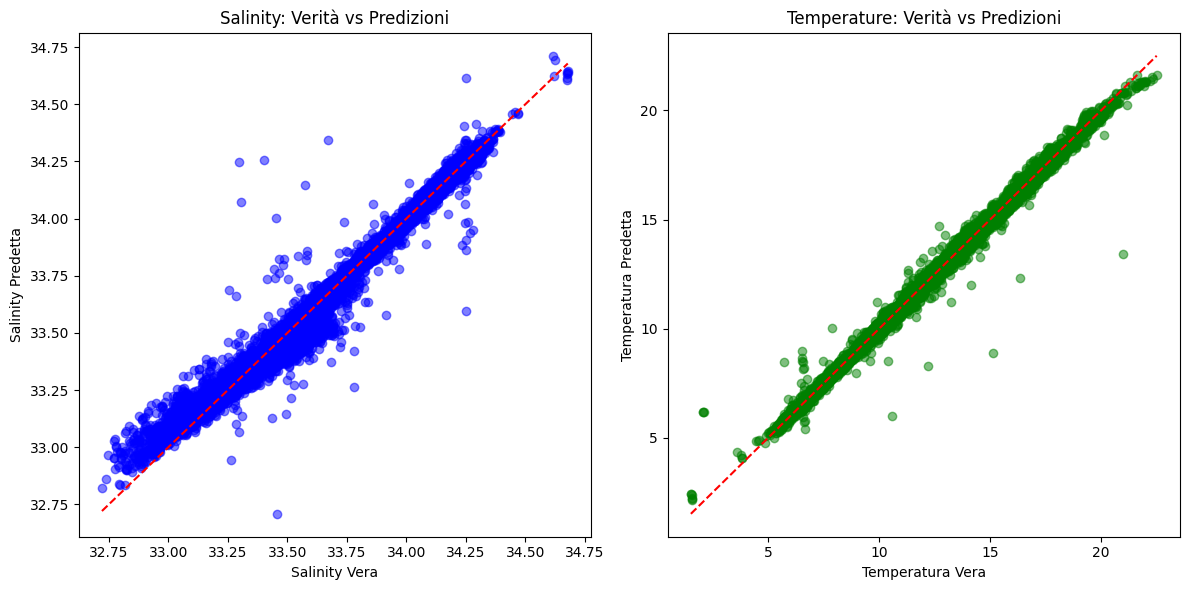

In [29]:
# Predizioni per Salinity e T
y_pred_Salinity = y_pred[:, 0]  # La prima colonna è la Salinty
y_pred_temp = y_pred[:, 1]  # La seconda colonna è la temperatura

# Grafico per Salinty
plt.figure(figsize=(12, 6))

# Scatter plot della Salinity vera vs predetta
plt.subplot(1, 2, 1)
plt.scatter(y_test['Salinity'], y_pred_Salinity, color='blue', alpha=0.5)
plt.plot([y_test['Salinity'].min(), y_test['Salinity'].max()], 
         [y_test['Salinity'].min(), y_test['Salinity'].max()], color='red', linestyle='--')
plt.title('Salinity: Verità vs Predizioni')
plt.xlabel('Salinity Vera')
plt.ylabel('Salinity Predetta')

# Grafico per Temperatura
# Scatter plot della Temperatura vera vs predetta
plt.subplot(1, 2, 2)
plt.scatter(y_test['T'], y_pred_temp, color='green', alpha=0.5)
plt.plot([y_test['T'].min(), y_test['T'].max()], 
         [y_test['T'].min(), y_test['T'].max()], color='red', linestyle='--')
plt.title('Temperature: Verità vs Predizioni')
plt.xlabel('Temperatura Vera')
plt.ylabel('Temperatura Predetta')

# Mostra i grafici
plt.tight_layout()
plt.show()


## **Considerazioni Finali**

Nel contesto del progetto CalCOFI, si è affrontata la previsione della salinità e della temperatura utilizzando un **modello di regressione di ridge**. La scelta di applicare un **kernel gaussiano**, approcciato tramite **Random Fourier Features**, ha permesso di ottenere un buon compromesso tra accuratezza e efficienza computazionale, riducendo il costo computazionale del kernel rispetto alla sua forma esatta.

I risultati ottenuti mostrano una buona capacità del modello di catturare le relazioni tra le variabili, con una predizione soddisfacente sia per la salinità che per la temperatura in funzione delle altre caratteristiche del dataset. L'uso delle Random Fourier Features ha permesso di estendere la regressione di ridge a spazi di caratteristiche ad alta dimensione, migliorando la flessibilità del modello senza incorrere in un eccessivo overfitting.

Un'analisi più approfondita potrebbe includere la valutazione dei modelli su nuovi set di dati per testare la generalizzabilità del modello. Inoltre, l'adozione di altre tecniche di regolarizzazione o l'uso di kernel differenti potrebbe portare a ulteriori miglioramenti delle prestazioni.


In generale, i risultati suggeriscono che l'approccio adottato è promettente per la previsione di variabili oceanografiche e che può essere esteso a contesti più complessi.

## **Referenze**

Random Fourier Fatures: https://random-walks.org/book/papers/rff/rff.html